In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP
os.environ['CUDA_VISIBLE_DEVICES']='6'

## Generate labeled dataset

In [2]:
bed_df = pd.read_csv('../data/pre-train/510/rna_selection.sorted.bed',
            sep='\t',names = ['Chr','Start','End','Gene','Label','Strand'])

In [3]:
bed_df['Label'].unique()

array(['intron,exon', 'exon', 'exon,intron', 'intron', 'intron,exon,UTR',
       'exon,UTR', 'exon,UTR,intron', 'UTR,intron,exon', 'UTR,exon',
       'intron,UTR,exon', 'UTR,exon,intron', 'intron,UTR',
       'exon,intron,UTR'], dtype=object)

In [4]:
set_size = 1000
file = open('/home/amber/multitask_RNA/data/pre-train/510/rna_seq.fa')
seq_list = file.readlines()
#label_set = bed_df['Label'].unique()
label_set = ['exon','intron']
mixed_seq = []
label = np.empty(set_size*len(label_set),dtype=np.dtype('U6'))
l_i = 0
for type in label_set:
    type_idx = bed_df.index[bed_df['Label']== type].tolist()
    rand_samp = random.sample(type_idx,set_size)
    selected_seq = [seq_list[(i)*2+1].strip().upper() for i in rand_samp]
    mixed_seq.extend(selected_seq)
    label[set_size*l_i:set_size*(l_i+1)]=type
    l_i += 1

In [5]:
projector = Pipeline([
    ("scaler", StandardScaler()),  # not sure it's a good idea. yeah, they have very different variances.
    #("pca", PCA(n_components=10)),
    ("umap", UMAP()),  # default n_neighbors works well
])

## GPN-400k human prediction cluster

In [54]:
import gpn.mlm
import torch
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
model = AutoModel.from_pretrained("/home/amber/multitask_RNA/replications/GPN/GPN_hg38/checkpoint-400000").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("/home/amber/multitask_RNA/replications/GPN/GPN_hg38/checkpoint-400000")
model.eval();

Some weights of the model checkpoint at /home/amber/multitask_RNA/replications/GPN/GPN_hg38/checkpoint-200000 were not used when initializing ConvNetModel: ['cls.decoder.3.bias', 'cls.decoder.0.weight', 'cls.decoder.0.bias', 'cls.decoder.2.weight', 'cls.decoder.3.weight', 'cls.decoder.2.bias']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
model_output = []
token_seq = tokenizer.batch_encode_plus(mixed_seq)
for seq_i in tqdm(range(0,len(token_seq['input_ids']),5)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+5]).to('cuda')
        output_seq = model(seq_batch).last_hidden_state.cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

100%|██████████| 400/400 [00:11<00:00, 34.20it/s]


In [56]:
model_output.shape

(2000, 510, 512)

In [63]:
umap_array=np.sum(model_output,axis = 1)
embedding = projector.fit_transform(umap_array)

In [61]:
umap_array = model_output[:,0,:]
embedding = projector.fit_transform(umap_array)

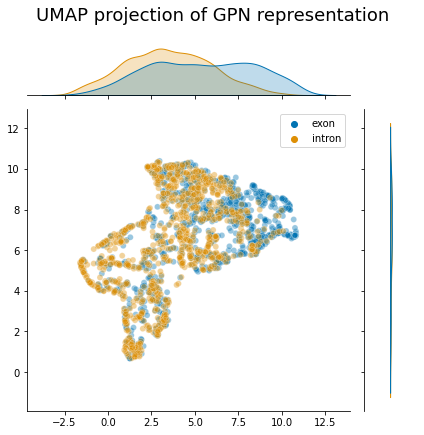

In [64]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of GPN representation', fontsize=18,y = 1.0)
plt.tight_layout()

## GPN plant prediction cluster

In [65]:
import gpn.mlm
import torch
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
model = AutoModel.from_pretrained("gonzalobenegas/gpn-arabidopsis").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("gonzalobenegas/gpn-arabidopsis")
model.eval();

Some weights of the model checkpoint at gonzalobenegas/gpn-arabidopsis were not used when initializing ConvNetModel: ['cls.decoder.3.bias', 'cls.decoder.0.weight', 'cls.decoder.0.bias', 'cls.decoder.2.weight', 'cls.decoder.3.weight', 'cls.decoder.2.bias']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
model_output = []
token_seq = tokenizer.batch_encode_plus(mixed_seq)
for seq_i in tqdm(range(0,len(token_seq['input_ids']),5)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+5]).to('cuda')
        output_seq = model(seq_batch).last_hidden_state.cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

 31%|███       | 124/400 [00:03<00:08, 34.41it/s]

In [ ]:
model_output.shape

(2000, 510, 512)

In [14]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.sum(model_output,axis = 1)
embedding = projector.fit_transform(umap_array)

In [ ]:
umap_array = model_output[:,0,:]
embedding = projector.fit_transform(umap_array)

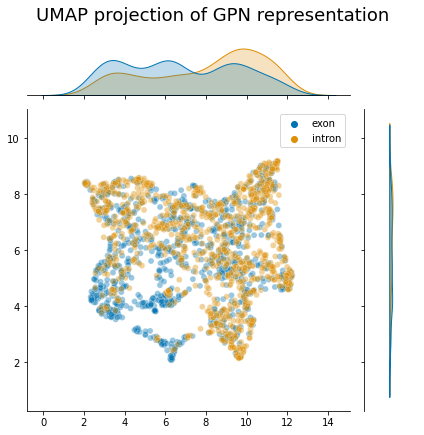

In [15]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of GPN representation', fontsize=18,y = 1.0)
plt.tight_layout()

## DNA_bert_6 prediction and cluster

In [16]:
from transformers import AutoTokenizer,AutoModelForMaskedLM
import os
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_6")
model = AutoModelForMaskedLM.from_pretrained("armheb/DNA_bert_6",output_hidden_states=True).to('cuda')

In [17]:
split_seq = []
model_output = []

for seq in mixed_seq:
    split_seq.append(' '.join([seq[i:i+6] for i in range(0, len(seq)-6+1, 1)]))
token_seq = tokenizer.batch_encode_plus(split_seq,max_length=507)
for seq_i in tqdm(range(0,len(token_seq['input_ids']),5)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+5]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 400/400 [00:20<00:00, 19.88it/s]


In [21]:
model_output.shape

(2000, 507, 768)

In [23]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.mean(model_output,axis = 1)
embedding = projector.fit_transform(umap_array)

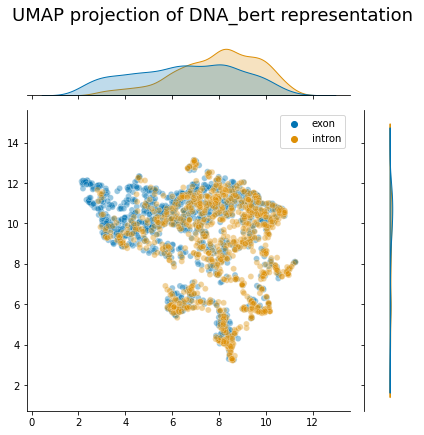

In [24]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of DNA_bert representation', fontsize=18,y = 1.0)
plt.tight_layout()

## Carp600k prediction and cluster

In [27]:
import torch
from sequence_models.constants import SPECIALS
from sequence_models.collaters import SimpleCollater
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import wandb
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
import rna_model
os.environ['CUDA_VISIBLE_DEVICES']='6'
device = torch.device("cuda")


In [29]:
import wandb
api = wandb.Api()
artifact = api.artifact('ambert/rna-selftrain/model-2qlb4cfk:v55')
artifact.download('./wandb/carp/600k')

'./wandb/carp/600k'

In [31]:
RNA='ACGTN'
RNA_ALPHABET = RNA+SPECIALS
collater = SimpleCollater(RNA_ALPHABET,False,False)
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.extend(module_out.cpu().detach().numpy())
        
    def clear(self):
        self.outputs = []

config={'model':'ByteNetLM',
                'lr':1e-3,
                'n_tokens':len(RNA_ALPHABET),
                'd_embedding' : 8, # dimension of embedding
                'd_model': 128, # dimension to use within ByteNet model, //2 every layer
                'n_layers' : 16, # number of layers of ByteNet block
                'activation': 'gelu',
                'kernel_size' : 5, # the kernel width
                'r' : 128, # used to calculate dilation factor
                'padding_idx' : RNA_ALPHABET.index('-') ,# location of padding token in ordered alphabet
                'dropout' : 0.1 ,
                }

model = rna_model.ByteNetLM(config['n_tokens'], config['d_embedding'], config['d_model'],
                        config['n_layers'], config['kernel_size'], config['r'], config['lr'],
                        padding_idx=config['padding_idx'], final_ln=True,causal=False, dropout=config['dropout'])
model.load_state_dict(torch.load('./wandb/carp/600k/model.ckpt')['state_dict'])
model.to(device)
model.eval();

In [32]:
save_output = SaveOutput()
hook_handles = []
handle = model.last_norm.register_forward_hook(save_output)
expand_seq = np.expand_dims(np.array(mixed_seq),axis = -1)
token_output = collater(expand_seq)[0]
for seq_i in tqdm(range(0,len(token_output),30)):
    seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
    output_seq = model(seq_batch).cpu().detach().numpy()

  0%|          | 0/67 [00:00<?, ?it/s]/tmp/ipykernel_2714439/1752877048.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
100%|██████████| 67/67 [00:01<00:00, 60.81it/s]


In [33]:
embed = np.array(save_output.outputs)
umap_array = np.mean(embed,axis = 1)
embedding = projector.fit_transform(umap_array)

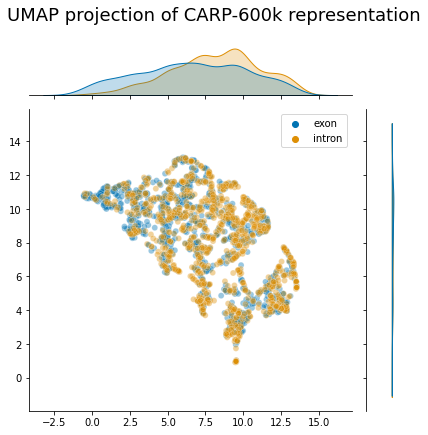

In [34]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of CARP-600k representation', fontsize=18,y = 1.0)
plt.tight_layout()


## Adjusted size CARP Prediction and Cluster

In [10]:
import torch
from sequence_models.constants import SPECIALS
from sequence_models.collaters import SimpleCollater
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import wandb
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
import rna_model
os.environ['CUDA_VISIBLE_DEVICES']='6'
device = torch.device("cuda")


In [11]:
RNA='ACGTN'
RNA_ALPHABET = RNA+SPECIALS
collater = SimpleCollater(RNA_ALPHABET,False,False)
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.extend(module_out.cpu().detach().numpy())
        
    def clear(self):
        self.outputs = []

In [12]:
config={'model':'ByteNetLM',
                'lr':1e-3,
                'n_tokens':len(RNA_ALPHABET),
                'd_embedding' : 9, # dimension of embedding
                'd_model': 320, # dimension to use within ByteNet model, //2 every layer
                'n_layers' : 15, # number of layers of ByteNet block
                'activation': 'relu',
                'kernel_size' : 5, # the kernel width
                'r' : 32, # used to calculate dilation factor
                'padding_idx' : RNA_ALPHABET.index('-') ,# location of padding token in ordered alphabet
                'dropout' : 0.1 ,
                }

model = rna_model.ByteNetLM(config['n_tokens'], config['d_embedding'], config['d_model'],
                        config['n_layers'], config['kernel_size'], config['r'], config['lr'],
                        padding_idx=config['padding_idx'], causal=False, dropout=config['dropout'])
model.load_state_dict(torch.load('./wandb/carp/model.ckpt')['state_dict'])
model.to(device)
model.eval();

In [13]:
save_output = SaveOutput()
hook_handles = []
handle = model.last_norm.register_forward_hook(save_output)

In [14]:
expand_seq = np.expand_dims(np.array(mixed_seq),axis = -1)
token_output = collater(expand_seq)[0]
for seq_i in tqdm(range(0,len(token_output),30)):
    seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
    output_seq = model(seq_batch).cpu().detach().numpy()

  0%|          | 0/67 [00:00<?, ?it/s]/tmp/ipykernel_2714439/1633952438.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
100%|██████████| 67/67 [00:02<00:00, 23.83it/s]


In [15]:
embed = np.array(save_output.outputs)
umap_array = np.mean(embed,axis = 1)
embedding = projector.fit_transform(umap_array)

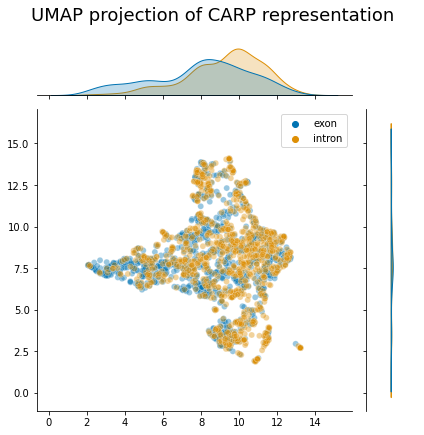

In [16]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of CARP representation', fontsize=18,y = 1.0)
plt.tight_layout()


## Best small roberta model Prediction and Cluster

In [39]:
from transformers import RobertaForMaskedLM
from tqdm import tqdm
import torch
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
from dna_tokenizer import DNATokenizer

In [41]:
model = RobertaForMaskedLM.from_pretrained('./wandb/small_roberta_lr8/',
                            output_hidden_states=True).to('cuda')
tokenizer = DNATokenizer('/home/amber/multitask_RNA/rna_self_train/vocab.txt')

In [49]:
split_seq = []
model_output = []

for seq in mixed_seq:
    split_seq.append(' '.join([seq[i:i+6] for i in range(0, len(seq)-6+1, 1)]))
token_seq = tokenizer.batch_encode_plus(split_seq,add_special_tokens=True,max_length=507)

In [51]:
for seq_i in tqdm(range(0,len(token_seq['input_ids']),30)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+30]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

100%|██████████| 67/67 [00:10<00:00,  6.69it/s]


In [52]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.mean(model_output,axis = 1)
embedding = projector.fit_transform(umap_array)

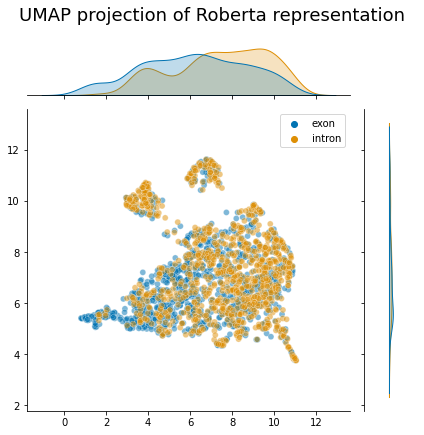

In [53]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of Roberta representation', fontsize=18,y = 1.0)
plt.tight_layout()

## to be done

## Full Roberta Full dataset Prediction and Cluster

In [ ]:
import wandb
api = wandb.Api()
artifact = api.artifact('ambert/huggingface/model-jsmf0s13:v0')
artifact.download('./wandb/small_roberta_lr8/')

## Roberta Prediction and Cluster

In [2]:
from transformers import RobertaForMaskedLM
from tqdm import tqdm
import torch
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
from dna_tokenizer import DNATokenizer

In [12]:
model = RobertaForMaskedLM.from_pretrained('/home/amber/multitask_RNA/DNA_BERT_rep/small-roberta-lr8/checkpoint-23500/',
                            output_hidden_states=True).to('cuda')
tokenizer = DNATokenizer('/home/amber/multitask_RNA/DNA_BERT_rep/vocab.txt')

In [13]:
split_seq = []
model_output = []

for seq in mixed_seq:
    split_seq.append(' '.join([seq[i:i+6] for i in range(0, len(seq)-6+1, 1)]))
token_seq = tokenizer.batch_encode_plus(split_seq,max_length=507)

In [14]:
for seq_i in tqdm(range(0,len(token_seq['input_ids']),30)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+30]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

100%|██████████| 34/34 [00:05<00:00,  6.77it/s]


In [15]:
model_output.shape

(1000, 505, 120)

In [16]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.mean(model_output,axis = 1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_array)

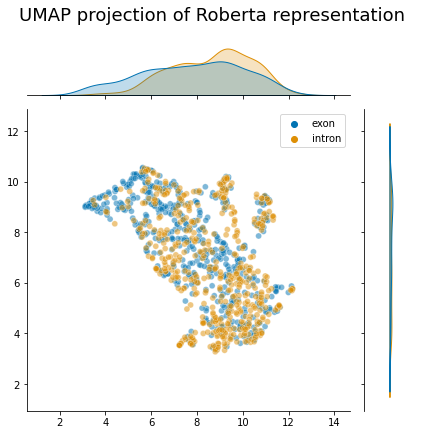

In [17]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of Roberta representation', fontsize=18,y = 1.0)
plt.tight_layout()